In [72]:
# Setting up
from __future__ import print_function, division
import os
import numpy as np
import torch
import pandas as pd
from skimage import io, transform

import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from training_utils import *
from data_loading import *


#transform1 = transforms.Compose([Rescale((256,256)), RandomCrop(224), ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
transform = transforms.Compose([transforms.ToPILImage(),transforms.Scale(256), transforms.RandomCrop(224), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


train = SkinLesionDataset(csv_file='../datasets/ISIC-2017_Training_Part3_GroundTruth.csv',
                                    root_dir='../datasets/ISIC-2017_Training_Data/', transform=transform)
validation  = SkinLesionDataset(csv_file='../datasets/ISIC-2017_Validation_Part3_GroundTruth.csv',
                                    root_dir='../datasets/ISIC-2017_Validation_Data/', transform = transform)
test = SkinLesionDataset(csv_file='../datasets/ISIC-2017_Test_v2_Part3_GroundTruth.csv',
                                    root_dir='../datasets/ISIC-2017_Test_v2_Data/', transform = transform)

train_data = DataLoader(train, batch_size=8,
                        shuffle=True, num_workers=1)
val_data = DataLoader(validation, batch_size=8,
                        shuffle=True, num_workers=1)
test_data = DataLoader(test, batch_size=8,
                        shuffle=True, num_workers=1)

dataset_sizes = {'train':len(train),'val':len(validation),'test':len(test)}
print(dataset_sizes)

dataloaders = {'train':train_data,'val':val_data,'test':test_data}
%load_ext autoreload
%autoreload 2

{'test': 600, 'train': 2000, 'val': 150}
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0 8
1 8
2 8


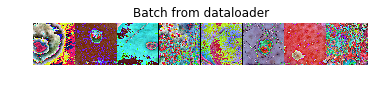

In [54]:
for i_batch, sample_batched in enumerate(test_data):
    print(i_batch, sample_batched['image'].shape[0])

    # observe 4th batch and stop.
    if i_batch == 2:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [59]:
X = np.zeros((2,2))
X[0] = np.array([0, 0])
X[1] = np.array([1, 1])

y = np.array([0, 1])
clf = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf.fit(X, y) 

print(clf.predict(np.array([[0., 0.],[1, 2]])))

[0 1]


In [69]:
a = np.arange(4)
b = [0, 1, 1, 3]
print(np.sum(a==b))

3


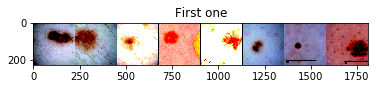

In [19]:
# visualizing some images
# Get a batch of training data
inputs = next(iter(train_data))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs['image'])

imshow(out, title="First one")

In [32]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features

#print(num_ftrs)
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [33]:

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, dataloaders,dataset_sizes,num_epochs=5)

Epoch 0/4
----------
train Loss: 0.0640 Acc: 0.7845
val Loss: 0.0765 Acc: 0.8000

Epoch 1/4
----------
train Loss: 0.0590 Acc: 0.7930
val Loss: 0.0574 Acc: 0.8133

Epoch 2/4
----------
train Loss: 0.0553 Acc: 0.8140
val Loss: 0.0588 Acc: 0.8000

Epoch 3/4
----------
train Loss: 0.0566 Acc: 0.8115
val Loss: 0.0574 Acc: 0.7800

Epoch 4/4
----------
train Loss: 0.0546 Acc: 0.8175
val Loss: 0.0625 Acc: 0.8067

Training complete in 95m 21s
Best val Acc: 0.813333


In [34]:
#dataloaders['test'] = dataloaders['test'][0:10]
test_model(model_conv, criterion, dataloaders,dataset_sizes)

test Loss: 0.0639 Acc: 0.8167

Testing complete in 13m 8s


In [53]:
inputs = next(iter(train_data))
inputs, labels = inputs['image'], inputs['class1']
xx = []
xx += labels.numpy()
inputs, labels = Variable(inputs), Variable(labels)
outputs = model_conv(inputs)
yy=[]
yy += outputs.data.numpy()

print(xx)
print(yy)

ValueError: operands could not be broadcast together with shapes (0,) (8,) 

In [82]:
# Actual Algorithm
models_list = (model_conv,model_conv)
model_data = train_meta_model(models_list, 1, dataloaders, dataset_sizes)

Training complete in 2m 33s


In [83]:
test_meta_model(model_data, dataloaders, dataset_sizes)

test  Acc: 0.8050

Testing complete in 13m 48s


0.80500000000000005